In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
df=pd.read_csv('../dataset/train.csv')

In [3]:
# Compressing records by considering the items which has more than 4 ratings and users who purchased more than 5 items
# Or give rating to more than 5 items

# including items with more than 4 ratings
itemRat_count = pd.DataFrame(df.groupby("item_id")["rating"].count())
itemRat_count = itemRat_count.loc[(itemRat_count["rating"] > 4)]
itemRat_count.reset_index(inplace=True)
#print('itemRat_count')
clothingReduced = df[df["item_id"].isin(itemRat_count["item_id"])]
#print(clothingRed)

In [4]:
# including users with more than 5 purchases
userRat_count = pd.DataFrame(clothingReduced.groupby("user_id")["rating"].count())
userRat_count = userRat_count.loc[(userRat_count.rating > 5)]
userRat_count.reset_index(inplace=True)
userRat_count.drop("rating", axis=1, inplace=True)
clothingReduced = clothingReduced[clothingReduced["user_id"].isin(userRat_count["user_id"])]
clothingReduced.reset_index(inplace=True, drop=True)

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

user_item_matx=clothingReduced.pivot_table(index='user_id', columns='item_id', values='rating', fill_value=0, aggfunc='count')
print({'Shape:': user_item_matx.shape})

# Compute user-user similarity matrix using cosine 
user_rating_prox = cosine_similarity(user_item_matx, user_item_matx)

# Form clusters 
def k_select(k):
    rating_kmeans = KMeans(n_clusters = k, max_iter = 40, algorithm = "auto", n_init = 30, random_state = 1017).fit(user_rating_prox)
    ssd = {"cluster_n": k, "ssd": rating_kmeans.inertia_}
    return ssd

# Range of number of clusters
k_list=list(range(2,20))
kmean_ssd = pd.DataFrame([k_select(k) for k in k_list])



{'Shape:': (2549, 4151)}


Text(0.5, 1.0, 'Select k based on elbow shape')

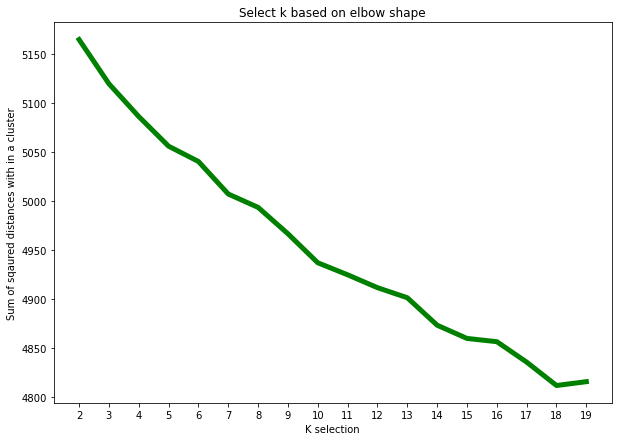

In [6]:
# Plot graph between number of clusters and ssd
plt.figure(figsize=(10, 7))
plt.plot(kmean_ssd["cluster_n"], kmean_ssd["ssd"], color="green", linewidth = 5)
plt.xticks(k_list, k_list)
plt.xlabel("K selection")
plt.ylabel("Sum of sqaured distances with in a cluster")
plt.title("Select k based on elbow shape")

In [7]:
# By looking at graph based on the elbow,  k=13 seems good to select
rating_kmeans = KMeans(n_clusters = 13, max_iter = 40,  algorithm = "auto", n_init = 30, random_state = 1017).fit(user_rating_prox)
rating_kmeans

KMeans(max_iter=40, n_clusters=13, n_init=30, random_state=1017)

In [8]:
# Gives cluster number with corresponding user id
# Users in a specific cluster are similar
user_clusters = pd.DataFrame(rating_kmeans.labels_, columns=["num of users"])
user_clusters

,num of users
0,9
1,9
2,1
3,9
4,9
...,...
2544,5
2545,12
2546,9
2547,9


In [9]:
# Adding extra column consists label as cluster number 
user_item_matx["cluster"] = list(rating_kmeans.labels_)
user_item_matx[["cluster"]].head()

item_id,cluster
user_id,
1023,9
1089,9
1434,1
2042,9
2105,9


In [10]:
user_item_matx

item_id,123373,123793,124204,124553,125424,125465,125564,126335,127081,127495,...,2958376,2958657,2959486,2960025,2960969,2962646,2963344,2963850,2966087,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
1023,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
1089,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
1434,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2042,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,9
2105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998194,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
998563,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12
999183,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


In [11]:
# https://www.geeksforgeeks.org/python-pandas-melt/
# Melt reshapes the dataframe with id_vars as rows
cluster_items_melt = user_item_matx.melt(id_vars="cluster", value_name="rating")
cluster_items_melt

,cluster,item_id,rating
0,9,123373,0
1,9,123373,0
2,1,123373,0
3,9,123373,0
4,9,123373,0
...,...,...,...
10580894,5,2966087,0
10580895,12,2966087,0
10580896,9,2966087,0
10580897,9,2966087,0


In [12]:
cluster_items_melt.sort_values(["cluster", "rating"], ascending=False, inplace=True)
user_item_matx_cp = user_item_matx.copy()
user_item_matx_cp.reset_index(inplace=True)

In [13]:
import evaluation as evalResult

def kMeansRec(d1):
    uid = d1['user_id']
    iid = d1['item_id']
    user_cluster = user_item_matx_cp[user_item_matx_cp.user_id == uid]
    user_cluster_ratings = cluster_items_melt[cluster_items_melt.cluster.isin(user_cluster.cluster)][:50]
    return user_cluster_ratings

evalResult.evaluate_recommendation(kMeansRec, -1)

{'average_of_recommendations': 14.779661016949152,
 'number_of_recommendations': 354,
 'total_test_cases': 38509,
 '% of recommendations': 0.9192656262172478}